# ART Example 1: Maximize Limonene Production

In this notebook we demonstrate the usage of the Automatic Recommendation Tool (ART) to recommend strain designs for improving limonene production. 

First we import the package:

In [2]:
import sys
sys.path.append('../')
    
from art.core import *

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/usr/local/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Load EDD study into a dataframe:

In [3]:
data_file = '../data/Limonene_data_for_ART.csv'

In [4]:
df = utils.load_study(data_file=data_file)

In [5]:
df.head()

,Study ID,Study Name,Line Name,Line Description,Strain(s),Media,Starting OD,Protocol Name,Assay ID,Assay Name,Type,Measurement Updated,X Units,Y Units,24
0,54255,Limonene data for ART,B-Mm,DH1 with single plasmid (medium-copy) expressi...,NaN,EZrich (Teknova) 1% Glucose,1.2,OD600,55297,B-Mm,Optical Density,2018-09-26 21:46:11.720910+00:00,hours,NaN,5.31867
1,54255,Limonene data for ART,A-Ml,DH1 with single plasmid (high-copy) expression...,NaN,EZrich (Teknova) 1% Glucose,1.2,OD600,55298,A-Ml,Optical Density,2018-09-26 21:46:11.720910+00:00,hours,NaN,4.88600
2,54255,Limonene data for ART,BL-Mm,DH1 with two plasmid (B + high with extra copy...,NaN,EZrich (Teknova) 1% Glucose,1.2,OD600,55299,BL-Mm,Optical Density,2018-09-26 21:46:11.720910+00:00,hours,NaN,4.40000
3,54255,Limonene data for ART,A-Mh,DH1 with single plasmid (high-copy) expression...,NaN,EZrich (Teknova) 1% Glucose,1.2,OD600,55300,A-Mh,Optical Density,2018-09-26 21:46:11.720910+00:00,hours,NaN,5.29333
4,54255,Limonene data for ART,A-Hl,DH1 with single plasmid (high-copy) expression...,NaN,EZrich (Teknova) 1% Glucose,2.5,OD600,55301,A-Hl,Optical Density,2018-09-26 21:46:11.720910+00:00,hours,NaN,5.03733


If needed, preprocess this dataframe, while keeping the same structure. 

More precisely, if the dataframe was exported directly from EDD it should keep at least 'Line Name', 'Measurement Type' and 'Value' columns.
        
If the dataframe was loaded from an EDD-exported CSV file it should contain at least 'Line Name' and 'Type' columns and a column for a time point. ART will then load only measurements from the first column for time point.
       

For this study, we only need to replace the hyphens in line names with somethng else.

In [6]:
df['Line Name'] = df['Line Name'].str.replace('-', '.')
df.head()

,Study ID,Study Name,Line Name,Line Description,Strain(s),Media,Starting OD,Protocol Name,Assay ID,Assay Name,Type,Measurement Updated,X Units,Y Units,24
0,54255,Limonene data for ART,B.Mm,DH1 with single plasmid (medium-copy) expressi...,NaN,EZrich (Teknova) 1% Glucose,1.2,OD600,55297,B-Mm,Optical Density,2018-09-26 21:46:11.720910+00:00,hours,NaN,5.31867
1,54255,Limonene data for ART,A.Ml,DH1 with single plasmid (high-copy) expression...,NaN,EZrich (Teknova) 1% Glucose,1.2,OD600,55298,A-Ml,Optical Density,2018-09-26 21:46:11.720910+00:00,hours,NaN,4.88600
2,54255,Limonene data for ART,BL.Mm,DH1 with two plasmid (B + high with extra copy...,NaN,EZrich (Teknova) 1% Glucose,1.2,OD600,55299,BL-Mm,Optical Density,2018-09-26 21:46:11.720910+00:00,hours,NaN,4.40000
3,54255,Limonene data for ART,A.Mh,DH1 with single plasmid (high-copy) expression...,NaN,EZrich (Teknova) 1% Glucose,1.2,OD600,55300,A-Mh,Optical Density,2018-09-26 21:46:11.720910+00:00,hours,NaN,5.29333
4,54255,Limonene data for ART,A.Hl,DH1 with single plasmid (high-copy) expression...,NaN,EZrich (Teknova) 1% Glucose,2.5,OD600,55301,A-Hl,Optical Density,2018-09-26 21:46:11.720910+00:00,hours,NaN,5.03733


Create Cycle 1 data by excluding 3 data points that were added to the initial study 

In [7]:
df_cycle1 = df.copy()
df_cycle1 = df_cycle1[~df_cycle1['Line Name'].isin(['BL.Mm', 'BL.Ml', 'BL.Mh'])]

Create test data for Cycle 1

In [8]:
df_test = df.copy()
df_test = df_test[df_test['Line Name'].isin(['BL.Mm', 'BL.Ml', 'BL.Mh'])]

## Cycle 1

Next we define a dictionary that contains all of the settings that ART will use to find the recommendations.

In [9]:
art_params = {}
art_params['input_var'] = ['ATOB_ECOLI','ERG8_YEAST','IDI_ECOLI','KIME_YEAST',
                           'MVD1_YEAST','Q40322_MENSP','Q8LKJ3_ABIGR',
                           'Q9FD86_STAAU','Q9FD87_STAAU']
art_params['response_var'] = ['4-isopropenyl-1-methyl-cyclohexene']
art_params['objective'] = 'maximize'
art_params['threshold'] = 0.2
art_params['num_recommendations'] = 10
art_params['verbose'] = 1
art_params['seed'] = 10
art_params['output_directory'] = '../results/Limonene'


In this case we have proteomics data which will be used to determine maximum production of limonene in terms of total protein concentrations. Then target protein concentrations will be reported back to the user.

In this data set the maximum value is 128 (mg/L) of Limonene. The objective is to predict strain designs which will maximize production. Successful designs are considered to be those that exceed the maximum observed production by 20%, as specified by the `threshold` variable.


In this notebook we demonstrate the usage of ART in a **step-by-step** fashion, so we set the flags for model building and recommendations to `False`.

In [10]:
art_params['build_model'] = False
art_params['recommend'] = False

Create an object for the test data

In [11]:
art_test = RecommendationEngine(df_test, **art_params)
art_test.df

Input Variables                                             \
               ATOB_ECOLI ERG8_YEAST IDI_ECOLI KIME_YEAST MVD1_YEAST   
Line Name                                                              
BL.Mh             1.95983    0.78130   2.59550    1.42496    4.10495   
BL.Ml             0.24012    0.19050   0.94884    0.38070    1.30811   
BL.Mm             1.25540    0.58985   2.29065    1.04860    3.19300   

                                                               \
          Q40322_MENSP Q8LKJ3_ABIGR Q9FD86_STAAU Q9FD87_STAAU   
Line Name                                                       
BL.Mh         13.59919      1.86762      0.39057      0.65389   
BL.Ml          2.72406      0.11237      0.05002      0.08503   
BL.Mm         11.31405      1.63235      0.25975      0.41045   

                          Response Variables  
          4-isopropenyl-1-methyl-cyclohexene  
Line Name                                     
BL.Mh                              127.99494  
BL.Ml                                6.72018  
BL.Mm                              119.81367

ART is first initialized with the parameter dictionary generated above. 

In [12]:
art = RecommendationEngine(df_cycle1, **art_params)
art.build_model()

Best pipeline: ElasticNetCV(StandardScaler(Normalizer(MinMaxScaler(MinMaxScaler(input_matrix)), Normalizer__norm=max)), ElasticNetCV__l1_ratio=0.15000000000000002, ElasticNetCV__tol=1e-05)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:29<00:00, 404.67draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,9.315305e-02,4.422982e-01,1.462307e-01,3.006090e-02,0.999965
Random Forest Regressor,7.435271e+00,4.050966e+01,7.632113e+00,1.135324e+02,0.869663
TPOT Regressor,1.143423e+01,1.039608e+02,1.262073e+01,2.900243e+02,0.667049
Support Vector Regressor,2.070242e+01,1.491689e+02,2.212358e+01,9.180428e+02,-0.053924
Kernel Ridge Regressor,1.069535e+01,7.543614e+01,1.132751e+01,2.427030e+02,0.721374
K-NN Regressor,1.503558e+01,1.774273e+02,1.290135e+01,3.925137e+02,0.549389
Gaussian Process Regressor,1.371691e-09,1.067820e-08,1.658088e-09,4.630792e-18,1.000000
Gradient Boosting Regressor,6.261583e-02,4.992972e-01,4.246974e-02,5.724422e-03,0.999993
Ensemble Model,9.010468e+00,7.330001e+01,9.966023e+00,1.805101e+02,0.792772


Take a look at Mean Absolute Error (MAE), Mean Relative AE (MRAE), Standard Deviation of the Absolute Error (StdAE) and R$^2$ of predictions for each individual model and the ensemble model.

Evaluate models on test data

In [24]:
X_test = art_test.df['Input Variables'].values
y_test = art_test.df['Response Variables'].values
art.evaluate_models(X_test, y_test)


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,290.710488,590.946968,158.440323,109615.923894,-34.790178
Random Forest Regressor,35.973699,132.105192,11.814710,1433.694394,0.531891
TPOT Regressor,71.289487,95.174619,44.930234,7100.916837,-1.318487
Support Vector Regressor,74.096364,119.781804,43.479950,7380.777219,-1.409863
Kernel Ridge Regressor,83.062916,74.268374,57.744805,10233.910556,-2.341426
K-NN Regressor,54.141485,177.921410,18.353236,3268.141640,-0.067066
Gaussian Process Regressor,68.196798,144.430001,34.905896,5869.224799,-0.916333
Gradient Boosting Regressor,37.136455,216.827726,3.741510,1393.115207,0.545141
Ensemble Model,50.171968,120.812792,23.422055,3065.819044,-0.001006


Evaluate models on train data

In [25]:
art.evaluate_models()


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,9.315305e-02,4.422982e-01,1.462307e-01,3.006090e-02,0.999965
Random Forest Regressor,7.435271e+00,4.050966e+01,7.632113e+00,1.135324e+02,0.869663
TPOT Regressor,1.143423e+01,1.039608e+02,1.262073e+01,2.900243e+02,0.667049
Support Vector Regressor,2.070242e+01,1.491689e+02,2.212358e+01,9.180428e+02,-0.053924
Kernel Ridge Regressor,1.069535e+01,7.543614e+01,1.132751e+01,2.427030e+02,0.721374
K-NN Regressor,1.503558e+01,1.774273e+02,1.290135e+01,3.925137e+02,0.549389
Gaussian Process Regressor,1.371691e-09,1.067820e-08,1.658088e-09,4.630792e-18,1.000000
Gradient Boosting Regressor,6.261583e-02,4.992972e-01,4.246974e-02,5.724422e-03,0.999993
Ensemble Model,9.010468e+00,7.330001e+01,9.966023e+00,1.805101e+02,0.792772


Plot observations vs. posterior predictive distributions for the train (black) and test(blue) data.

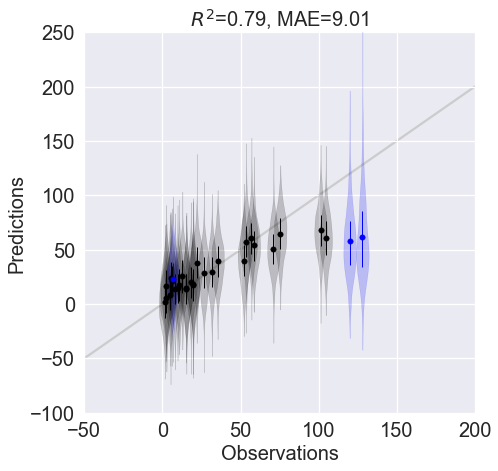

In [26]:
plot.predictions_distr_vs_observations(art, cv_flag=False, widths=8, 
                                       X_test=X_test, observed_test=y_test,
                                       xlim=[[-50, 200]], ylim=[[-100, 250]])

Sample the space of protein expressions in search of those that maximize the limonene production.

Perform sampling-based optimization and find recommendations with default options (`niter=100000` for number of samples collected, `alpha=None` for a purely exploitative strategy, and `rel_eng_accuracy=20%` for relative engineering accuracy):

In [17]:
draws = art.parallel_tempering_opt()
art.recommend(draws)

Finished 2.00 percent in 3.043618 s Acceptance rate = 0.3525Adding DE jump with weight 20
Finished 99.00 percent in 108.751443 s Acceptance rate = 0.266919
Run Complete


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,4-isopropenyl-1-methyl-cyclohexene
0,0.210467,1.327463,3.158487,0.413204,2.249686,11.643243,4.655928,0.446959,0.543795,82.342633
1,0.168229,0.992986,3.262478,0.401294,2.242982,11.564634,4.648075,0.438649,0.621512,82.046547
2,0.173191,1.280789,3.284687,0.411372,2.073877,11.589146,4.706476,0.421579,0.688475,81.891044
3,0.217886,0.974747,3.228631,0.405483,2.238396,11.684475,4.594105,0.448662,0.552076,81.816430
4,0.205228,1.217749,3.241586,0.414771,2.185778,11.542409,4.712419,0.556559,0.594692,81.675371
5,0.182666,1.284837,3.261029,0.401372,2.251627,11.512361,4.685976,0.520349,0.744602,81.520261
6,0.273203,1.313864,3.295376,0.407302,2.278826,11.311913,4.616265,0.477662,0.545211,81.352723
7,0.234940,1.427510,3.256411,0.386058,2.164260,11.670886,4.722949,0.420077,0.658063,81.268104
8,0.214070,0.724753,3.245143,0.413167,2.250223,11.629898,4.600947,0.449267,0.671452,81.018387
9,0.234203,1.306449,3.264384,0.413494,2.211044,11.410356,4.656731,0.509666,0.719750,81.012919


(Neglected recommendations are those that do not satisfy the engineering accuracy requirement)

The Table above provides a set of predictions which if followed should maximize the chance of successful strain engineering.

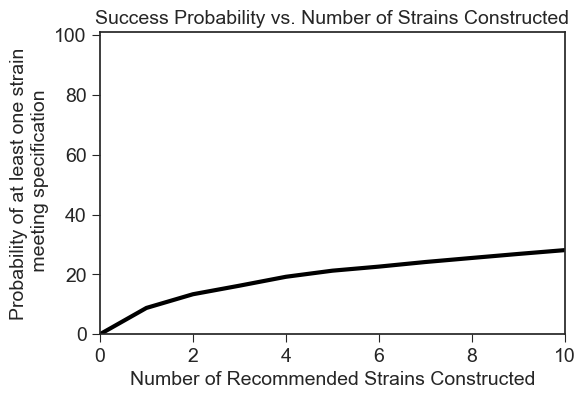

In [18]:
cumulative_success_prob = art.calculate_success_prob(current_best=art.find_current_best())
plot.success_prob(art, cumulative_success_prob)

Plot first two principal components of draws (top) and recommendations (bottom) (in green) with observed data (in red)

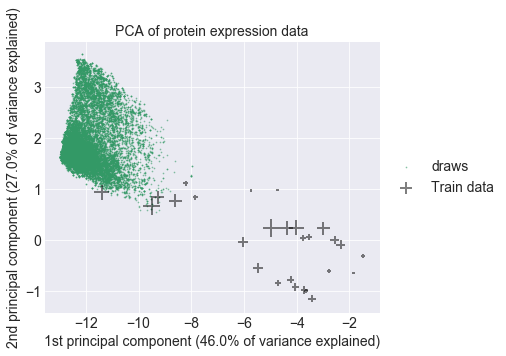

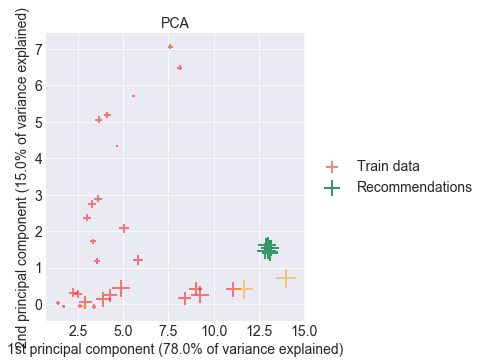

In [19]:
plot.draws_pc(art, draws, scale=3, plot_draws=True, plot_kde=False)
plot.recommendations_pc(art, scale=3, X_test=X_test, objective_value_y_test=y_test)


Heatmap of the mean of the final model as function of the two principal components of input varibles:

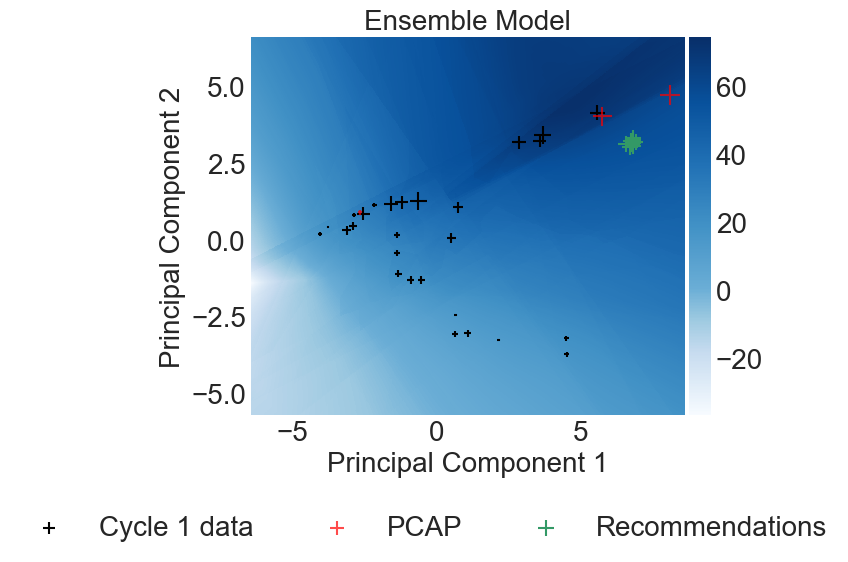

In [20]:
model = art
plot.plot_model(model, art, X_test, y_test, scaling_factor=1.5, 
                midpoint=0.6, 
                title='Ensemble Model', plot_points=True)


Visualize input data pairwise. The size of each point represents the level of output variable (limonene production).

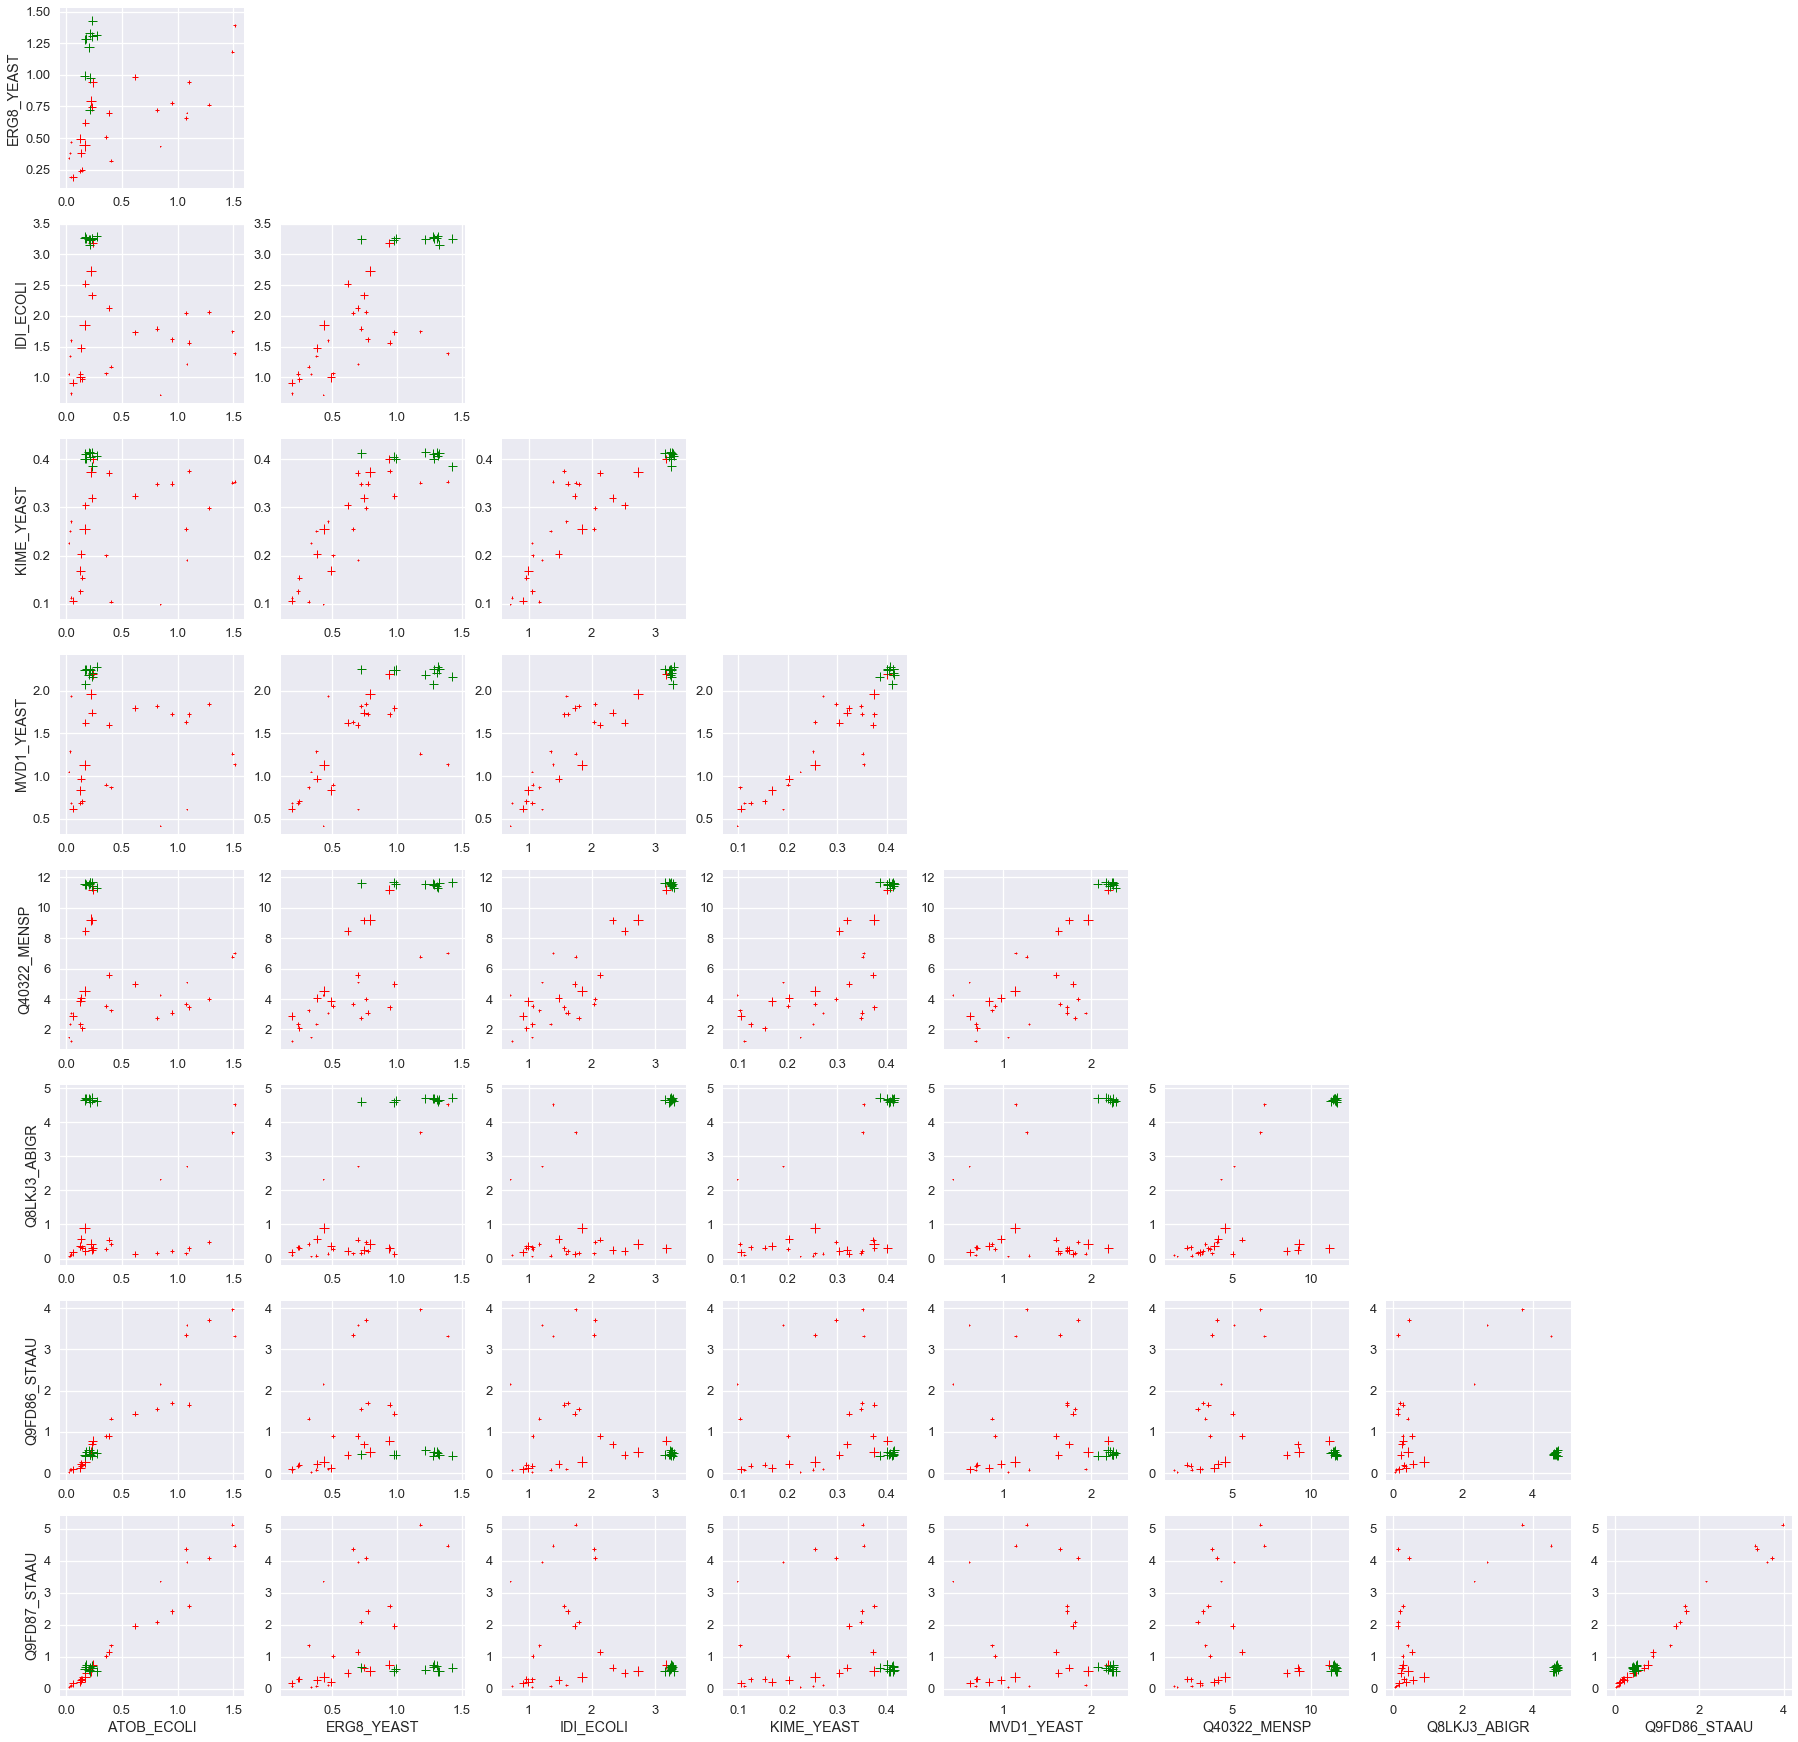

In [21]:
plot.data_pairwise(art, recommendations=art.recommendations)

In [27]:
utils.save_pkl_object(art)